# Imports

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import os

import torchvision.transforms.functional as TF

import zipfile
import glob
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
import torchvision.models as models
from datetime import datetime
import wandb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
random_state = 2137
np.random.seed(random_state)
torch.manual_seed(random_state)
torch.cuda.manual_seed(random_state)

# loading datasets

In [9]:
#reading csv
annotations = pd.read_csv('../input/cats-and-dogs-breeds-classification-oxford-dataset/annotations/annotations/list.txt')

#The first 4 rows consists of the information about breeds
#Reading the data after 5th row
annotations = annotations.loc[5:,]

#Processing the columns
annotations[['CLASS-ID','SPECIES','BREED','ID']] = annotations['#Image CLASS-ID SPECIES BREED ID'].str.split(expand=True) 

#Dropping unnecessary columns
annotations = annotations.drop('#Image CLASS-ID SPECIES BREED ID',axis=1)

#renaming the columns
annotations = annotations.rename(columns={"CLASS-ID": "image", "SPECIES": "CLASS-ID", 'BREED' : "SPECIES", "ID":"BREED ID"})


#converting the object type to int type
annotations[["CLASS-ID","SPECIES","BREED ID"]] = annotations[["CLASS-ID","SPECIES","BREED ID"]].astype(int)

In [10]:
annotations

,image,CLASS-ID,SPECIES,BREED ID
5,Abyssinian_100,1,1,1
6,Abyssinian_101,1,1,1
7,Abyssinian_102,1,1,1
8,Abyssinian_103,1,1,1
9,Abyssinian_104,1,1,1
...,...,...,...,...
7349,yorkshire_terrier_96,37,2,25
7350,yorkshire_terrier_97,37,2,25
7351,yorkshire_terrier_98,37,2,25
7352,yorkshire_terrier_99,37,2,25


Species stands here for dog (2) or a cat (1), breed ID is the ID of a breed given we know what type of animal it is, and class-ID is a unique ID for each species and breed together. Overall there is 25 cats breeds and 12 dog breeds. image is a column of filenames. All the files here are in jpg format

### RUN THIS CELL ONLY ONCE!!!

In [11]:
# adding the extension to image so it can be used to access the real image
annotations['image'] = annotations['image'].apply(lambda x : str(x)+'.jpg')
annotations = annotations.reset_index()
annotations = annotations.drop('index',axis=1)

#Extracting the classname/breed of the animal
annotations['classname'] = annotations['image'].apply(lambda x: str(x)[:str(x).rindex('_')])

# Adding information about cat or dog based on the 'Species' column to the 'classname' column
annotations['classname'] = annotations.apply(lambda row: f"{('dog' if row['SPECIES'] == 2 else 'cat')}_{row['classname']}", axis=1)
annotations

,image,CLASS-ID,SPECIES,BREED ID,classname
0,Abyssinian_100.jpg,1,1,1,cat_Abyssinian
1,Abyssinian_101.jpg,1,1,1,cat_Abyssinian
2,Abyssinian_102.jpg,1,1,1,cat_Abyssinian
3,Abyssinian_103.jpg,1,1,1,cat_Abyssinian
4,Abyssinian_104.jpg,1,1,1,cat_Abyssinian
...,...,...,...,...,...
7344,yorkshire_terrier_96.jpg,37,2,25,dog_yorkshire_terrier
7345,yorkshire_terrier_97.jpg,37,2,25,dog_yorkshire_terrier
7346,yorkshire_terrier_98.jpg,37,2,25,dog_yorkshire_terrier
7347,yorkshire_terrier_99.jpg,37,2,25,dog_yorkshire_terrier


# Creating the dataset class to make the data easily accesable

In [12]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.folder_patch = '/kaggle/input/cats-and-dogs-breeds-classification-oxford-dataset/images/images/'
        self.annotations = file_list
        self.transform = transform
        self.filelength = len(file_list)

    def __len__(self):
        return self.filelength

    def __getitem__(self, idx):
        classID = self.annotations['CLASS-ID'].iloc[idx]
        img_path = self.annotations['image'].iloc[idx]
        img_path = self.folder_patch + img_path
        img = Image.open(img_path)
        
        has_alpha_channel = img.mode == 'RGBA'
        if has_alpha_channel == True:
            print("image has Alpha channel")
            img = img.convert('RGB')
        if self.transform is not None:
            try:
                img = self.transform(img)
            except RuntimeError as e:
                print(f"Exception: {e}")
                print("Shape before normalization:", img.size)
                print(img_path)
                tot = transforms.ToTensor()
                img_tensor = tot(img)
                print("Input Tensor Shape:", img_tensor.shape)
                print("Input Tensor Values:", img_tensor)
        #else:
            #print("No transformations to be done")
        return img, classID-1

In [13]:
all_images = CatsDogsDataset(annotations)

# Plotting sample images

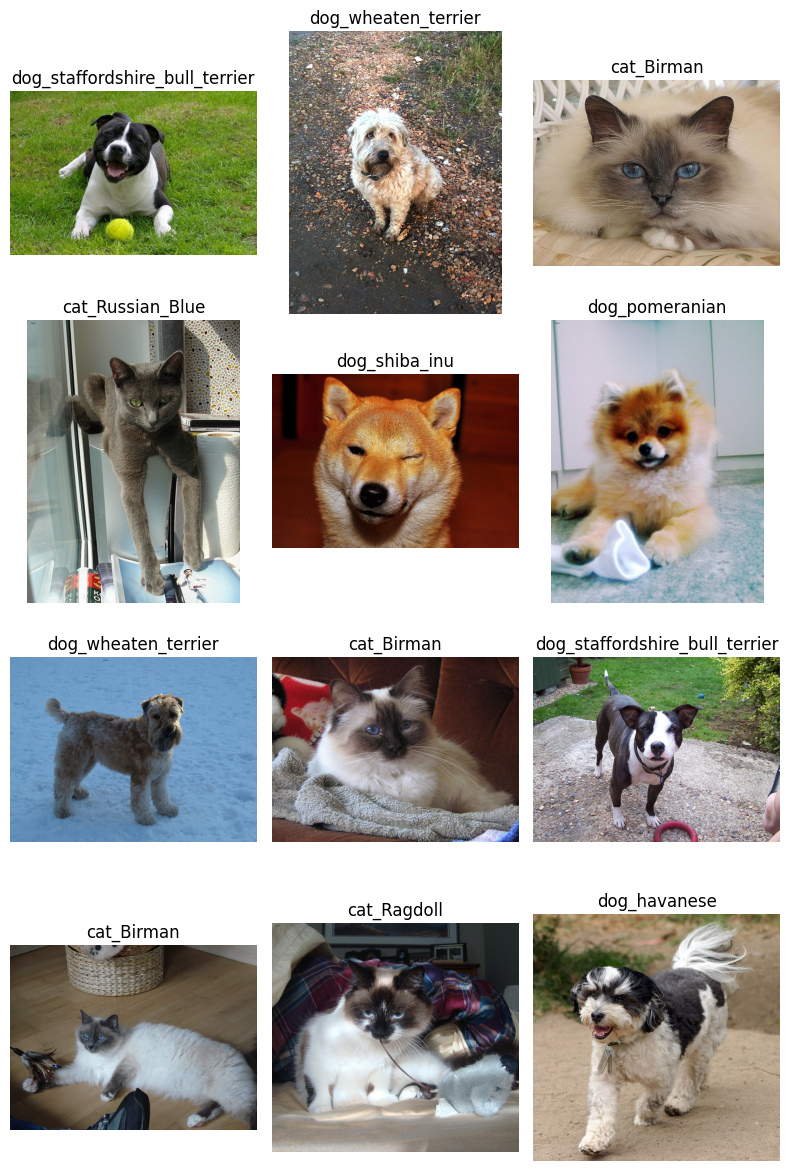

In [41]:
num_images = 12
plt.figure(figsize=(8, 12))
for i in range(num_images):
    idx = random.randint(0, len(all_images) - 1)
    image, classID = all_images[idx]
    classname = all_images.annotations['classname'].iloc[idx]
    plt.subplot(4, 3, i+1)
    plt.imshow(image)
    plt.title(classname)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Analysis of image resolutions (I couldn't find any information about it in a dataset desription)

In [ ]:
dataset_size = len(all_images)
print(dataset_size)
image_sizes = []
for i in range(dataset_size):
    img, _ = all_images[i]
    image_sizes.append(img.size)

There are 3 images in a dataset that have an additional alpha channel, what needs to be considered while handling with  teh images

In [ ]:
unique_count = len(set(image_sizes)) 
print("Number of unique elements:", unique_count)

There are many different sizes of images

In [ ]:
x_values, y_values = zip(*image_sizes)

plt.title('x_values') 
plt.hist(x_values,bins=100) 
plt.show()

plt.title('y_values')
plt.hist(y_values,bins=100)
plt.show()

resoulutions above 1000 pixels in one axis are not representative

## 2D histogram is a very useful tool to give the insight what is the distribution of resolutions. It also visualizes what are the image shapes

In [ ]:
filtered_data = [(x, y) for x, y in image_sizes if x < 1000 and y < 1000]

x_values, y_values = zip(*filtered_data)
plt.hist2d(x_values, y_values, bins=(50, 50), cmap='viridis', cmin = 1)

plt.xlim(0, 1000)
plt.ylim(0, 1000)

# Add color bar for reference
cbar = plt.colorbar()
cbar.set_label('Frequency')

# Add labels and title
plt.xlabel('horizontal')
plt.ylabel('vertical')
plt.title('2D Histogram for resolutions')

# Show the plot
plt.show()

Most of the images have rectangular shapes with proportions around 5x4 or 3x5 which should be also true in real life scenarions

### Let's have a closer look:

In [ ]:
hist, x_edges, y_edges, _ = plt.hist2d(x_values, y_values, bins=(30, 30), cmap='inferno', cmin = 1, vmax=30)

plt.xlim(0, 1000)
plt.ylim(0, 1000)

# Add color bar for reference
cbar = plt.colorbar()
cbar.set_label('Frequency')

cbar.set_ticks([0, 2, 4, 6, 10, 20, 30])

plt.xlabel('horizontal')
plt.ylabel('vertical')
plt.title('2D Histogram for rare resolutions')
plt.show()

It can be observed that resolutions below 250 and 550 pixels in any axis also appear rarely

# Plotting the distribution of animal breed to check if they are really distributed uniformally

In [ ]:
plt.hist(annotations['classname'], bins=37, edgecolor='black',rwidth=0.5)
plt.xticks(rotation='vertical')
plt.xlabel('breed indexes')
plt.ylabel('Frequency')
plt.title('Frequency of different breeds in dataset')
plt.show()

The breeds are actually almost uniformally distributed